In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

In [2]:
plt.rcParams['figure.figsize']=(12,9)

In [6]:
wine = load_wine()
df = pd.DataFrame(wine.data,columns=wine.feature_names)
df['target'] = wine.target

In [7]:
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


In [8]:
import seaborn as sns

<Axes: xlabel='features', ylabel='value'>

C:\Users\ELmohannd\anaconda3\envs\pandas_playground\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


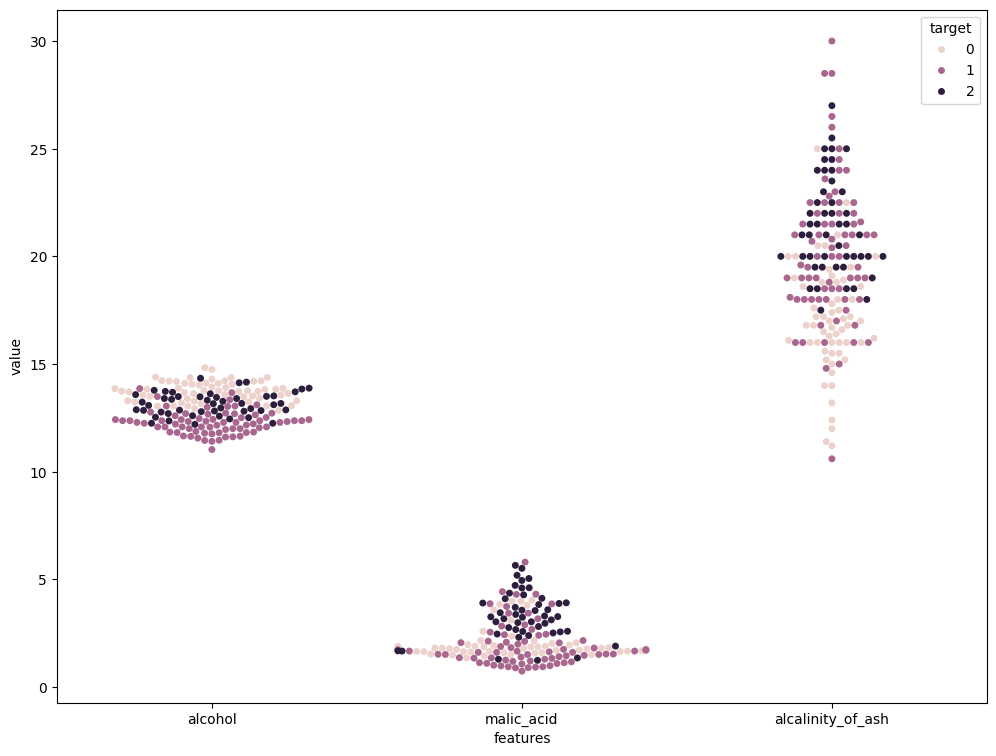

In [10]:
plot_data = pd.melt(df[['alcohol','malic_acid','alcalinity_of_ash','target']],id_vars='target',var_name='features',value_name='value')
sns.swarmplot(plot_data,x='features',y='value',hue='target')

In [11]:
df.target.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

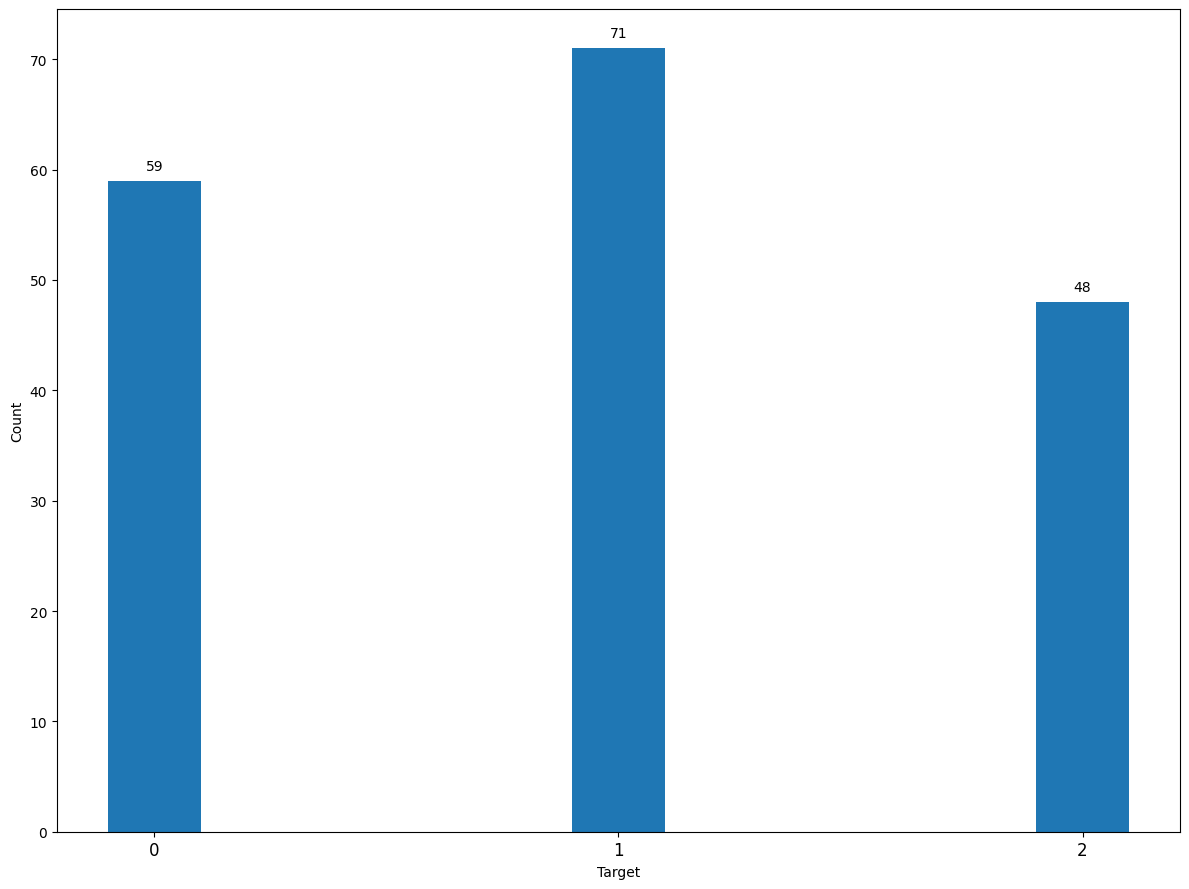

In [14]:
fig,ax = plt.subplots()
ax.bar(df.target.value_counts().sort_index().index,df.target.value_counts().sort_index().values,width=0.2)
ax.set_xlabel('Target')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2])
ax.set_xticklabels([0,1,2],fontsize=12)
for i,x in enumerate(df.target.value_counts().sort_index().values):
    plt.text(i,x+1,s=str(x),ha='center')
plt.tight_layout()

In [57]:
from sklearn.model_selection import train_test_split
x = df.drop('target',axis=1)
y = df['target']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,stratify=y,shuffle=True,random_state=42)

In [58]:
x_train.shape

(124, 13)

In [59]:
x_test.shape

(54, 13)

In [60]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
gbc = GradientBoostingClassifier(max_depth=5)
gbc.fit(x_train,y_train)
pred = gbc.predict(x_test)
print(round(f1_score(y_test,pred,average='weighted'),3))

0.908


In [61]:
x_train_v1,y_train_v1,x_test_v1,y_test_v1 = x_train.copy(),y_train.copy(),x_test.copy(),y_test.copy()

In [62]:
x_train_v1.var(axis=0)

alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [63]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
scaled_x_train_v1 = sc.fit_transform(x_train_v1)
scaled_x_test_v1 = sc.fit_transform(x_test_v1)

In [64]:
scaled_x_train_v1.var(axis=0)

array([0.04522384, 0.04352695, 0.02076785, 0.03023374, 0.02719754,
       0.04637992, 0.07828214, 0.05504516, 0.03328847, 0.04094397,
       0.03467828, 0.06639094, 0.06152349])

In [65]:
x_train_var = x_train_v1.drop(['ash','magnesium'],axis=1)
x_test_var = x_test_v1.drop(['ash','magnesium'],axis=1)

In [66]:
gbc.fit(x_train_var,y_train)
pred2 = gbc.predict(x_test_var)
print(round(f1_score(y_test,pred2,average='weighted'),3))

0.963


In [68]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif
f1 = []
for i in range(1,14):
    skb = SelectKBest(mutual_info_classif,k=i)
    skb.fit(x_train_v1,y_train)
    sel_x_train = skb.transform(x_train_v1)
    sel_x_test = skb.transform(x_test_v1)
    gbc.fit(sel_x_train,y_train)
    pred2 = gbc.predict(sel_x_test)
    score = round(f1_score(y_test,pred2,average='weighted'),3)
    f1.append(score)
f1

[0.759,
 0.926,
 0.981,
 0.981,
 0.981,
 0.981,
 0.981,
 0.963,
 0.963,
 0.963,
 0.945,
 0.908,
 0.908]

In [71]:
skb = SelectKBest(mutual_info_classif,k=3)
skb.fit(x_train_v1,y_train_v1)
feat = skb.get_support()
print(x_train_v1.columns[feat])
sel_x_train = skb.transform(x_train_v1)
sel_x_test = skb.transform(x_test_v1)

Index(['flavanoids', 'color_intensity', 'proline'], dtype='object')


In [72]:
gbc.fit(sel_x_train,y_train_v1)

GradientBoostingClassifier(max_depth=5)

In [73]:
sel_pred = gbc.predict(sel_x_test)
print(round(f1_score(y_test_v1,sel_pred,average='weighted'),3))

0.981


In [77]:
from sklearn.feature_selection import RFE
f1 = []
for k in range(1,14):
    rfe = RFE(estimator=gbc,n_features_to_select=k,step=1)
    rfe.fit(x_train_v1,y_train_v1)
    rfe_x_train = rfe.transform(x_train_v1)
    rfe_x_test = rfe.transform(x_test_v1)
    gbc.fit(rfe_x_train,y_train_v1)
    pred3 = gbc.predict(rfe_x_test)
    score = round(f1_score(y_test_v1,pred3,average='weighted'),3)
    f1.append(score)
f1

[0.622,
 0.816,
 1.0,
 0.981,
 0.926,
 0.963,
 0.869,
 0.908,
 0.908,
 0.908,
 0.908,
 0.908,
 0.908]

In [78]:
rfe = RFE(estimator=gbc,n_features_to_select=3,step=10)
rfe.fit(x_train_v1,y_train_v1)
ref_x_train = rfe.transform(x_train_v1)
ref_x_test = rfe.transform(x_test_v1)
gbc.fit(ref_x_train,y_train_v1)
pred_rfe = gbc.predict(ref_x_test)
print(round(f1_score(y_test_v1,pred_rfe,average='weighted'),3))

1.0


In [79]:
!pip install boruta

   ---------------------------------------- 0.0/56.6 kB ? eta -:--:--
   ------- -------------------------------- 10.2/56.6 kB ? eta -:--:--
   --------------------- ------------------ 30.7/56.6 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 56.6/56.6 kB 498.8 kB/s eta 0:00:00


In [80]:
from boruta import BorutaPy

In [1]:
# this code requires numpy version 1.9 and python version 2.8 to run 
#selector = BorutaPy(estimator=gbc,random_state=42)
#selector.fit(x_train_v1.values,y_train_v1.values)
#b_x_train = selector.transform(x_train_v1.values)
#b_x_test = selector.transform(x_test_v1.values)
#gcb.fit(b_x_train,y_train_v1)
#boruta_pred = gcb.predict(b_x_test)
#print(round(f1_score(y_test_v1,boruta_pred,average='weighted'),3))